In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import *
pd.options.mode.chained_assignment = None  # default='warn'

needLogos = False

In [2]:
#Helper Functions

def GetProbabilityOfConversion(probs):
    conv = []
    for p in probs:
        conv.append(p[1])
        
    return conv

In [3]:
def GetThirdDownStandardData(d):
    data = d.copy()
    data.drop(['passer_player_name', 'passer_player_id',
           'rusher_player_name', 'rusher_player_id',
           'receiver_player_name', 'receiver_player_id'],
          axis=1, inplace=True)

    data = data.loc[data.season_type=='REG']
    data = data.loc[(data.half_seconds_remaining>120) &
                             (data.wp>=.25) & (data.wp<=.75)]
    
    clean_data = data.loc[(data.play_type.isin(['pass','run'])) & (data.epa.isna()==False)].copy()

    clean_data.play_type.loc[clean_data['pass']==1] = 'pass'
    clean_data.play_type.loc[clean_data.rush==1] = 'run'

    clean_data.reset_index(drop=True, inplace=True)
    
    
    third_down = clean_data.loc[(clean_data.down==3) & (clean_data.goal_to_go == 0)]
    
    teams = third_down['posteam']
    years = third_down['year']
    
    third_down = third_down[['ydstogo', 'yardline_100', 
                             'game_seconds_remaining', 'third_down_converted']]


    
    
    return third_down, teams, years
    

In [4]:
def GetThirdDownTeamBasedData(d):
    data = d.copy()
    data.drop(['passer_player_name', 'passer_player_id',
           'rusher_player_name', 'rusher_player_id',
           'receiver_player_name', 'receiver_player_id'],
          axis=1, inplace=True)

    data = data.loc[data.season_type=='REG']
    data = data.loc[(data.half_seconds_remaining>120) &
                             (data.wp>=.25) & (data.wp<=.75)]
    
    clean_data = data.loc[(data.play_type.isin(['pass','run'])) & (data.epa.isna()==False)].copy()

    clean_data.play_type.loc[clean_data['pass']==1] = 'pass'
    clean_data.play_type.loc[clean_data.rush==1] = 'run'

    clean_data.reset_index(drop=True, inplace=True)
    
    
    third_down = clean_data.loc[(clean_data.down==3) & (clean_data.goal_to_go == 0)]
    
    teams = third_down['posteam']
    years = third_down['year']
    
    third_down = third_down[['posteam', 'year', 'ydstogo', 'yardline_100', 
                             'game_seconds_remaining', 'third_down_converted']]
    
    
    non_third_down = clean_data.loc[(clean_data.down!=3)]


    non_third_down = non_third_down[['play_id', 'pass', 'rush', 'year', 'posteam','play_type', 'epa', 'yards_gained',
                       'cpoe']]


    grouped_non_third_down_data_rush = non_third_down[non_third_down['rush']==1].groupby(['posteam', 'year', 'play_type'], as_index=False).agg({'yards_gained':'mean', 
                                                              'epa': 'mean',
                                                              'cpoe':'mean',
                                                              'play_id':'count','yards_gained':'mean',
                                                              'pass':'sum','rush':'sum'})

    grouped_non_third_down_data_pass = non_third_down[non_third_down['rush']==0].groupby(['posteam', 'year', 'play_type'], as_index=False).agg({'yards_gained':'mean', 
                                                              'epa': 'mean',
                                                              'cpoe':'mean',
                                                              'play_id':'count','yards_gained':'mean',
                                                              'pass':'sum','rush':'sum'})
    
    
    train_merge = pd.merge(grouped_non_third_down_data_rush, grouped_non_third_down_data_pass,  how='left', left_on=['posteam','year'], right_on = ['posteam','year'], suffixes = ['_rush', '_pass'])

    train = pd.merge(third_down, train_merge,  how='left', left_on=['posteam','year'], right_on = ['posteam','year'], suffixes = ['_reg', '_group'])

    train = train[['ydstogo', 'yardline_100', 'game_seconds_remaining',
       'third_down_converted', 'yards_gained_rush',
       'epa_rush',  'play_id_rush', 'yards_gained_pass', 'epa_pass', 'cpoe_pass',
       'play_id_pass']]
    
    
    train.columns =['ydstogo', 'yardline_100', 'game_seconds_remaining',
       'third_down_converted', 'yards_gained_rush',
       'epa_rush',  'Rushes', 'yards_gained_pass', 'epa_pass', 'cpoe_pass',
       'Passes']
    
    train['Pass Rate'] = train.apply(
             lambda row: (row['Passes']/ (row['Passes']+row['Rushes'])),axis=1)
    
    return train, teams, years


In [5]:
def GeneratePlayByPlayData(years, standard):
    
    data = pd.DataFrame()
    for i in years:  
        i_data = pd.read_csv('https://github.com/guga31bb/nflfastR-data/blob/master/data/' \
                             'play_by_play_' + str(i) + '.csv.gz?raw=True',
                             compression='gzip', low_memory=False)
        i_data['year'] = str(i)
        print(i)

        data = data.append(i_data, sort=True)

    if standard:
        train, teams, years = GetThirdDownStandardData(data)
    else:
        train, teams, years = GetThirdDownTeamBasedData(data)
        
    return train, teams, years

In [6]:
def SplitTrainData(data, random_state, test_size = 0.25):
    labels = np.array(data["third_down_converted"])
    features= data.drop('third_down_converted', axis = 1)
    features = np.array(features)
    
    
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = test_size, random_state = random_state)
    return train_features, test_features, train_labels, test_labels 

In [7]:
def TrainLogisticRegression(x_train, y_train, x_test, random):
    clf = LogisticRegression(random_state=random).fit(x_train, y_train)
    Y_pred = clf.predict(x_test)
    return clf, Y_pred

In [8]:
def TrainLinearSVM(x_train, y_train, x_test, random):
    clf = LinearSVC(random_state = random)
    clf.fit(x_train, y_train)
    Y_pred = clf.predict(x_test)
    return clf, Y_pred

In [9]:
def classification_metrics(Y_pred, Y_true):
    
    accuracy = accuracy_score(Y_true, Y_pred)
    fpr, tpr, thresholds = roc_curve(Y_true, Y_pred)                                      
    auc_ = auc(fpr, tpr) 
    precision = precision_score(Y_true, Y_pred)
    recall = recall_score(Y_true, Y_pred)
    f1 = f1_score(Y_true, Y_pred)
    return accuracy, auc_, precision, recall, f1

In [10]:
def display_metrics(classifierName, Y_pred, Y_true):
    print("______________________________________________")
    print(("Classifier: "+classifierName))
    acc, auc_, precision, recall, f1score = classification_metrics(Y_pred,Y_true)
    print(("Accuracy: "+str(acc)))
    print(("AUC: "+str(auc_)))
    print(("Precision: "+str(precision)))
    print(("Recall: "+str(recall)))
    print(("F1-score: "+str(f1score)))
    print("______________________________________________")
    print("")

In [21]:
def CreateStandardThirdDownPrediction():
    random = 45
    test_size = 0.25
    YEARS = [2019,2018,2017,2016,2015]
    trainData, trainTeams, trainYears = GeneratePlayByPlayData(YEARS, True)
    
    train_features, test_features, train_labels, test_labels = SplitTrainData(trainData, random, test_size)
    logistic, log_predictions = TrainLogisticRegression(train_features, train_labels, test_features, random)
    svm, svm_predictions = TrainLinearSVM(train_features, train_labels, test_features, random)
    
    
    display_metrics("Logistic Regression", log_predictions, test_labels)
    display_metrics("SVM", svm_predictions, test_labels)
    
    
    testYears = [2020]
    testData, testTeams, testYears = GeneratePlayByPlayData(testYears, True)
    trueResults = np.array(testData["third_down_converted"])
    features= testData[['ydstogo', 'yardline_100', 
                             'game_seconds_remaining']]
    features = np.array(features)
    
    test_predictions = logistic.predict_proba(features)
    pred = GetProbabilityOfConversion(test_predictions)
    testData['Conversion_%'] = pred
    testData['Team'] = testTeams
    testData['Year'] = testYears
    
    actual_conversion = testData.groupby(['Team'], as_index=False).agg({'ydstogo': 'count', 'third_down_converted':'mean'})
    expected_conversion = testData.groupby(['Team'], as_index=False).agg({'ydstogo': 'count', 'Conversion_%':'mean'})
    merged = pd.merge(actual_conversion, expected_conversion,  how='left', left_on=['Team'], right_on = ['Team'], suffixes = ['_act', '_exp'])
    final_conv = pd.DataFrame(merged[['Team', 'ydstogo_act', 'third_down_converted', 'Conversion_%']])
    final_conv.columns = ['Team', 'Plays', 'Actual Conversion', 'Expected Conversion']
    final_conv['Conversion Over Expected'] = final_conv.apply(
             lambda row: (row['Actual Conversion']- row['Expected Conversion'])*100,axis=1)
    
    
    return final_conv

In [30]:
def CreateTeamBasedThirdDownPrediction():
    random = 45
    test_size = 0.25
    YEARS = [2019,2018,2017,2016,2015]
    trainData, trainTeams, trainYears = GeneratePlayByPlayData(YEARS, False)
    
    
    train_features, test_features, train_labels, test_labels = SplitTrainData(trainData, random, test_size)
    logistic, log_predictions = TrainLogisticRegression(train_features, train_labels, test_features, random)
    svm, svm_predictions = TrainLinearSVM(train_features, train_labels, test_features, random)
    
    
    display_metrics("Logistic Regression", log_predictions, test_labels)
    display_metrics("SVM", svm_predictions, test_labels)
    
    
    testYears = [2020]
    testData, testTeams, testYears = GeneratePlayByPlayData(testYears, False)

    trueResults = np.array(testData["third_down_converted"])
    features= testData[['ydstogo', 'yardline_100', 'game_seconds_remaining', 'yards_gained_rush',
       'epa_rush',  'Rushes', 'yards_gained_pass', 'epa_pass', 'cpoe_pass',
       'Passes', 'Pass Rate']]
    features = np.array(features)
    
    test_predictions = logistic.predict_proba(features)
    pred = GetProbabilityOfConversion(test_predictions)
    testData['Conversion_%'] = pred
    testData['Team'] = np.array(testTeams)
    testData['Year'] = np.array(testYears)

    actual_conversion = testData.groupby(['Team'], as_index=False).agg({'ydstogo': 'count', 'third_down_converted':'mean'})
    expected_conversion = testData.groupby(['Team'], as_index=False).agg({'ydstogo': 'count', 'Conversion_%':'mean'})
    merged = pd.merge(actual_conversion, expected_conversion,  how='left', left_on=['Team'], right_on = ['Team'], suffixes = ['_act', '_exp'])
    final_conv = pd.DataFrame(merged[['Team', 'ydstogo_act', 'third_down_converted', 'Conversion_%']])
    final_conv.columns = ['Team', 'Plays', 'Actual Conversion', 'Expected Conversion']
    final_conv['Conversion Over Expected'] = final_conv.apply(
             lambda row: (row['Actual Conversion']- row['Expected Conversion'])*100,axis=1)
    
    
    return final_conv

In [13]:
def GenerateGraphs(d):
    COLORS = {'ARI':'#97233F','ATL':'#A71930','BAL':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#00143F',
          'CIN':'#FB4F14','CLE':'#FB4F14','DAL':'#B0B7BC','DEN':'#002244','DET':'#046EB4','GB':'#24423C',
          'HOU':'#C9243F','IND':'#003D79','JAX':'#136677','KC':'#CA2430','LA':'#002147','LAC':'#2072BA',
          'LV':'#C4C9CC','MIA':'#0091A0','MIN':'#4F2E84','NE':'#0A2342','NO':'#A08A58','NYG':'#192E6C',
          'NYJ':'#203731','PHI':'#014A53','PIT':'#FFC20E','SEA':'#7AC142','SF':'#C9243F','TB':'#D40909',
          'TEN':'#4095D1','WAS':'#FFC20F'}

    import os
    import urllib.request
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox
    import matplotlib.pyplot as plt

    urls = pd.read_csv('https://raw.githubusercontent.com/statsbylopez/BlogPosts/master/nfl_teamlogos.csv')

    if needLogos:
        for i in range(0,len(urls)):
            urllib.request.urlretrieve(urls['url'].iloc[i], os.getcwd() + '/logos/' + urls['team_code'].iloc[i] + '.png')


    def getImage(path):
        return OffsetImage(plt.imread(path), zoom=.42)


    logos = os.listdir(os.getcwd() + '/logos')

    logo_paths = []
    logos.remove('STL.png')
    logos.remove('OAK.png')
    logos.remove('SD.png')
    logos.remove('.DS_Store')
    logos = sorted(logos)
    for i in logos:
        logo_paths.append(os.getcwd() + '/logos/' + str(i))
        
        
    COE = d.copy()

    #Add team colors
    COE['color'] = COLORS.values()

    #Add path column where each row will have the location of the team's logo
    COE['path'] = logo_paths

    #Sort from highest to lowest pass rate
    COE.sort_values('Conversion Over Expected',ascending=False,inplace=True)

    fig, ax = plt.subplots(figsize=(30,20))

    #Add logos

    #X data as an array from 0-31 (for 32 teams)
    for x0, y0, path in zip(np.arange(0,32),COE['Conversion Over Expected']+.01,COE['path']):
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False, fontsize=10)
        ax.add_artist(ab)

    #Create bar chart, setting color(s) equal to the 32 team color series
    ax.bar(np.arange(0,32),COE['Conversion Over Expected'],color=COE.color,width=.5)

    #Add league average line
    ax.axhline(y=COE['Conversion Over Expected'].mean(),linestyle='--',color='black')

    #Add grid
    ax.grid(zorder=0,alpha=.6,axis='y')
    ax.set_axisbelow(True)

    #Set x-ticks labels to be team abbreviations
    ax.set_xticks(np.arange(0,32))
    ax.set_xticklabels(COE['Team'],fontsize=16)

    #Manually adjust y-axis
    ax.set_yticks(np.arange(-10,15))
    ax.set_yticklabels(np.arange(-10,15),fontsize=16)

    #Set labels and give source
    ax.set_ylabel('3rd Down Conversion % Over Expected',fontsize=24,labelpad=20)
    ax.set_title('3rd Down Conversion % Over Expected - 2020 \n Win Prob. Between 20-80%, Final Two Minutes Excluded',
                 fontsize=26,pad=20)
    plt.figtext(.85,.05,'Data: nflfastR',fontsize=14)

    #League average line label
    plt.text(30.5,.53,'NFL Average',fontsize=14)

    plt.savefig('3dcoe.png',dpi=400)

In [14]:
standard_data = CreateStandardThirdDownPrediction()
GenerateGraphs(standard_data)

2019
2018
2017
2016
2015


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


______________________________________________
Classifier: Logistic Regression
Accuracy: 0.6477819347942276
AUC: 0.6133706024540758
Precision: 0.5968778696051423
Recall: 0.4251144538914323
F1-score: 0.4965622612681436
______________________________________________

______________________________________________
Classifier: SVM
Accuracy: 0.4812934259754142
AUC: 0.5510444702611981
Precision: 0.4368872549019608
Recall: 0.9326357096141269
F1-score: 0.5950344252034216
______________________________________________

2020
       ydstogo  yardline_100  game_seconds_remaining  third_down_converted  \
4           14          45.0                  3459.0                   0.0   
9           20          75.0                  3355.0                   0.0   
14           3          68.0                  3029.0                   0.0   
17           8          76.0                  2985.0                   0.0   
18          10          78.0                  2969.0                   0.0   
...        

2019
2018
2017
2016
2015


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


______________________________________________
Classifier: Logistic Regression
Accuracy: 0.6560662747194014
AUC: 0.6263380044844706
Precision: 0.6028911564625851
Recall: 0.46370176586003925
F1-score: 0.5242144177449168
______________________________________________

______________________________________________
Classifier: SVM
Accuracy: 0.5916622127204704
AUC: 0.500731305027046
Precision: 0.5555555555555556
Recall: 0.0032701111837802484
F1-score: 0.006501950585175552
______________________________________________

2020
4         SF
9        ARI
14        SF
17       ARI
18       ARI
        ... 
15165    PHI
15173    WAS
15176    WAS
15179    PHI
15184    WAS
Name: posteam, Length: 2816, dtype: object
-------------Teams
      ydstogo  yardline_100  game_seconds_remaining  third_down_converted  \
0          14          45.0                  3459.0                   0.0   
1          20          75.0                  3355.0                   0.0   
2           3          68.0           

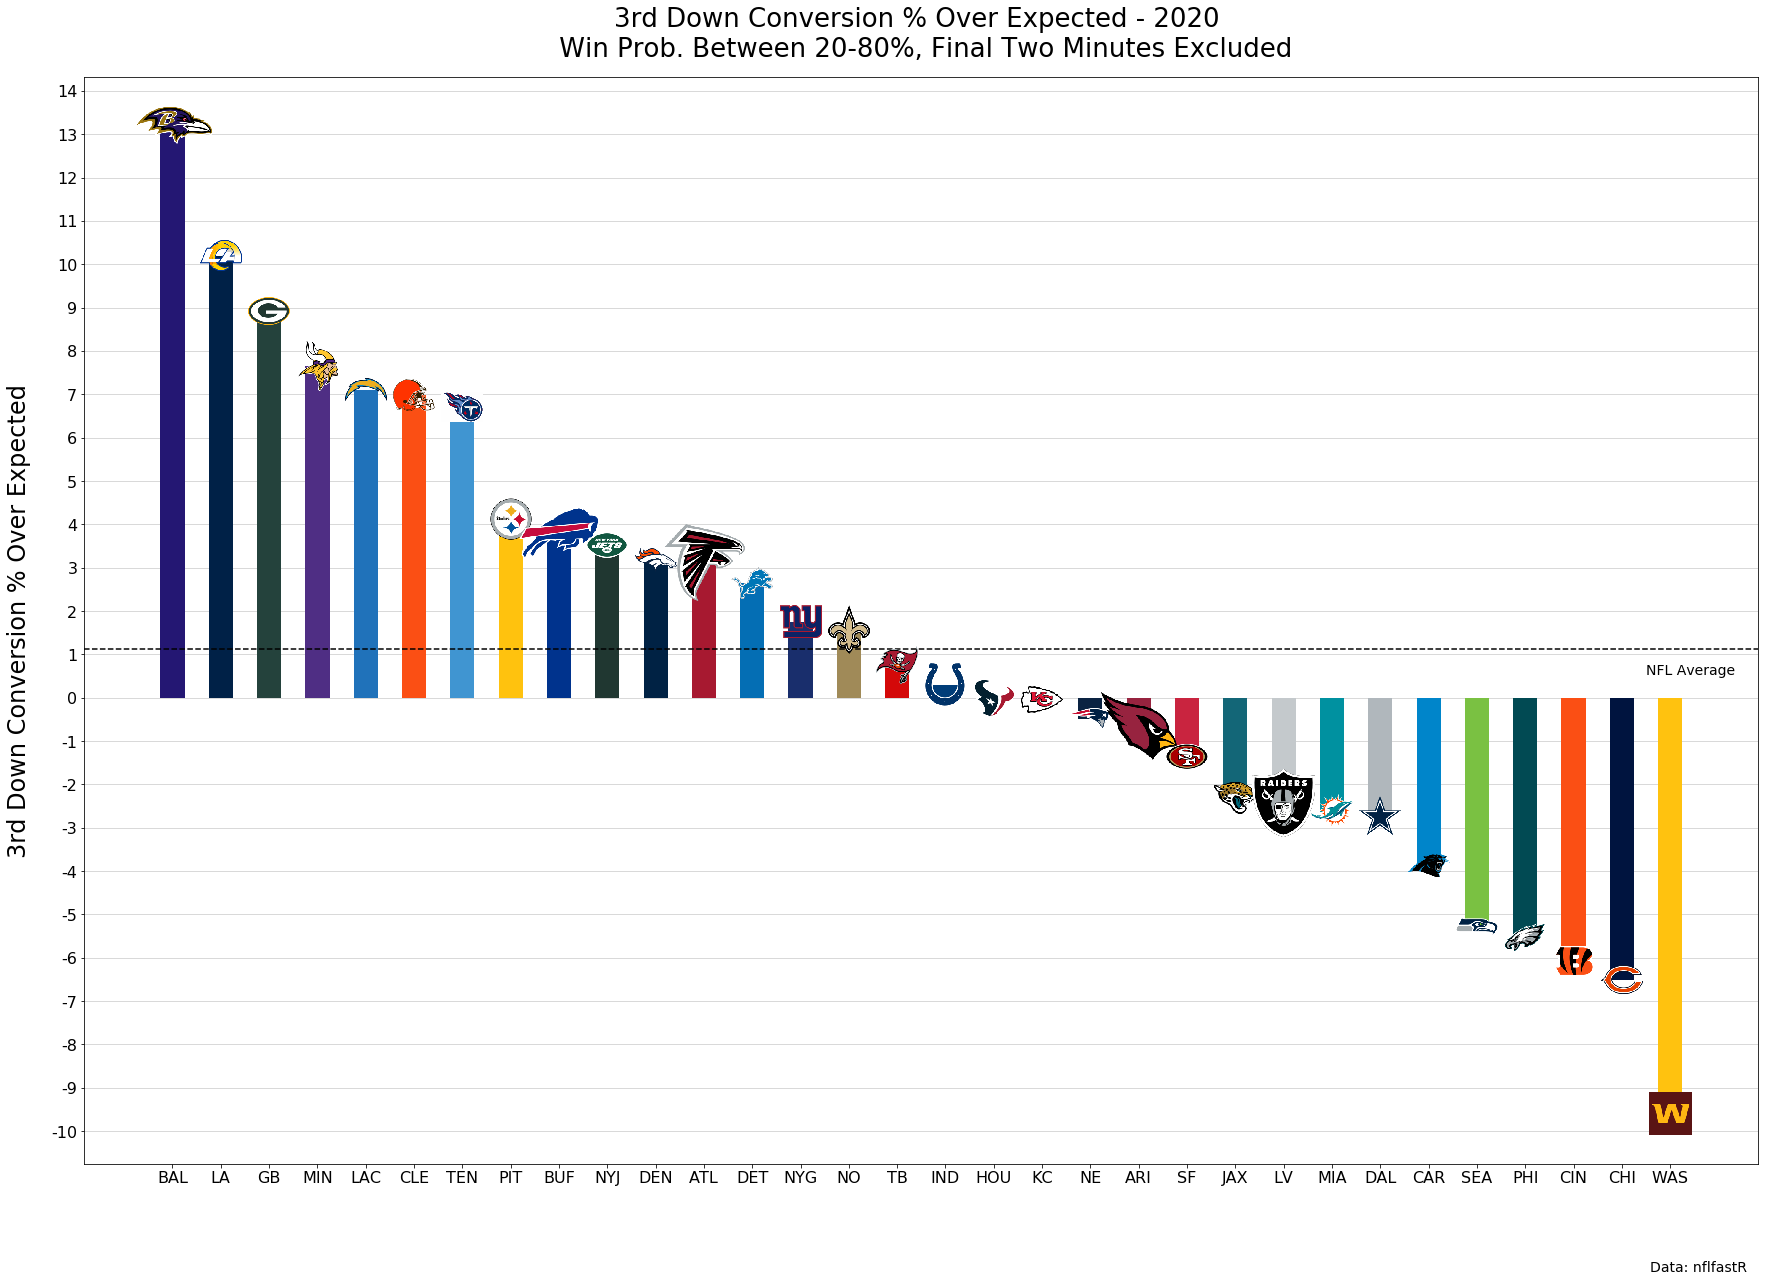

In [29]:
team_based_data = CreateTeamBasedThirdDownPrediction()
GenerateGraphs(team_based_data)